# Summer analysis 2023: ndvi+ndmi+marginalization res 10

This notebook joins ndvi (res10), ndmi (res10) and marginalization (res8 to res10 through centroids) and creates categories for NDVI and marg in order to create the following analysis:

Analysis 1: Average min, mean, max data by marginalization group
Min, mean and max ndvi and ndmi is calculated by marginalization group.

Analisis 2: Zones that may recieve irrigation within urban spaces and its relation with marginalization
Places without vegetation are discarted. (ndvi without locations with water, marshy surfaces, artificial structures, rocks adn clouds)
10% max and 10% min ndmi_diff are located, ploted and exported to csv.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [2]:
city = 'Chihuahua'

In [40]:
#Save csvs to output>figures>ndmi_ndmi_marg_bycity?
csv_dataset = True 
#"averagerasterdata_bymarg": csv containing ndvi and ndmi min, mean, median and max, along with the marginalization category
#"ndmi_diffextremes_marg": csv containing the top 10% and bottom 10% ndmi_diff (humidity variation/conservation) related to the marginalization degree.

#Save figures to output>figures>ndmi_ndmi_marg_bycity?
save_plots = True

## Data download

Data download - NDVI

In [4]:
# Downloading NDVI res 10 data
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndvi_res10.shape)
ndvi_res10.head(2)

(23079, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8a48f485b6d7fff,"POLYGON ((-105.90813 28.83295, -105.90745 28.8...",10,0.243684,0.071290,0.262449,0.314077,0.121822,0.192256,-0.000914,Chihuahua
1,8a48f4bb519ffff,"POLYGON ((-105.90814 28.84422, -105.90745 28.8...",10,0.291416,0.087752,0.298189,0.409398,0.165390,0.244008,-0.001680,Chihuahua


Data download - NDMI

In [5]:
# Downloading NDMI res 10 data
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndmi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndmi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndmi_res10.shape)
ndmi_res10.head(2)

(23079, 11)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,city
0,8a48f485b787fff,"POLYGON ((-105.90666 28.82745, -105.90597 28.8...",10,-0.028496,0.114715,-0.052087,0.161382,-0.102804,0.264186,0.000058,Chihuahua
1,8a48f4bb5047fff,"POLYGON ((-105.91520 28.84691, -105.91451 28.8...",10,-0.049022,0.110258,-0.068642,0.125910,-0.108744,0.234653,0.000306,Chihuahua


Data download - Municipalities (in order to download marginalization)

In [6]:
mun_schema = 'metropolis'
mun_table = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(3, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,08002,08,002,Aldama,"POLYGON ((-105.87156 29.63195, -105.87133 29.6...",Chihuahua
1,08004,08,004,Aquiles Serdán,"POLYGON ((-105.89534 28.69113, -105.89447 28.6...",Chihuahua


Data download - Marginalization

In [7]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())
cvegeo_list

['08002', '08004', '08019']

In [8]:
# donwload hexagons with marg data
hex_marg = gpd.GeoDataFrame()
marg_table = 'hex_bins_marg_2020'
marg_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {marg_schema}.{marg_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_marg = pd.concat([hex_marg, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_marg.shape)
hex_marg.head(2)

(443, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-105.90519 28.83324, -105.91068 28.8...",8848f485b7fffff,08002,833.00775,6.096932,43.55031,11.423024,0.002705,0.000681,0.000681,0.004075,1.294450,59.26109,8.454274,15.668009,122.563261,0.957418
1,"POLYGON ((-105.91548 28.83222, -105.92097 28.8...",8848f485b3fffff,08002,1823.55460,7.451186,46.08840,11.157258,0.125986,0.058545,0.058545,0.234181,0.530437,83.46144,9.695144,25.923208,123.654060,0.965939


## Data treatment

### Data treatment - Bring marginalization data (res8) to ndvi (res10)

Find ndvi centroids in order to intersect res10 info with a single res8 hex

In [9]:
#Find centroids
ndvi_res10_calc = ndvi_res10.to_crs("EPSG:6372")
centroids = ndvi_res10_calc.centroid
centroids = centroids.to_crs("EPSG:4326")

#Turn into gdf
centroids_gdf = gpd.GeoDataFrame(centroids)
centroids_gdf = centroids_gdf.rename(columns={0:'geometry'})

#Review result
print(centroids_gdf.shape)
centroids_gdf.head(2)

(23079, 1)


,geometry
0,POINT (-105.90823 28.83369)
1,POINT (-105.90824 28.84497)


Intersect centroids with orginal ndvi data to keep hex_id data

In [10]:
centroids_hexid = gpd.overlay(centroids_gdf,ndvi_res10,keep_geom_type=True)

columns_tokeep = ['hex_id','geometry']
centroids_hexid = centroids_hexid[columns_tokeep]

#Review result
print(centroids_hexid.shape)
centroids_hexid.head(2)

(23079, 2)


,hex_id,geometry
0,8a48f485b6d7fff,POINT (-105.90823 28.83369)
1,8a48f4bb519ffff,POINT (-105.90824 28.84497)


Intersect centroids with marginalization data

In [11]:
centroids_marg = gpd.overlay(centroids_hexid,hex_marg,keep_geom_type=True)

columns_tokeep = ['hex_id','pobtot','im_2020','imn_2020']
centroids_marg = centroids_marg[columns_tokeep]

#Review result
print(centroids_marg.shape)
centroids_marg.head(2)

(21707, 4)


,hex_id,pobtot,im_2020,imn_2020
0,8a48f485b6d7fff,833.00775,122.563261,0.957418
1,8a48f485b6effff,833.00775,122.563261,0.957418


Merge centroids_marg back with res10 geometry

In [12]:
ndvi_marg = pd.merge(ndvi_res10,centroids_marg, on='hex_id')

#Review result
print(ndvi_marg.shape)
ndvi_marg.head(2)

(21707, 14)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,pobtot,im_2020,imn_2020
0,8a48f485b6d7fff,"POLYGON ((-105.90813 28.83295, -105.90745 28.8...",10,0.243684,0.071290,0.262449,0.314077,0.121822,0.192256,-0.000914,Chihuahua,833.00775,122.563261,0.957418
1,8a48f4bb519ffff,"POLYGON ((-105.90814 28.84422, -105.90745 28.8...",10,0.291416,0.087752,0.298189,0.409398,0.165390,0.244008,-0.001680,Chihuahua,2415.74500,122.158749,0.954258


### Data treatment - Merge NDVI_MARG with NDMI

In [13]:
ndmi_res10_clean = ndmi_res10.drop(columns=['geometry','res','city'])
ndvi_ndmi_marg = ndvi_marg.merge(ndmi_res10_clean, left_on='hex_id', right_on='hex_id')

#Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(21707, 21)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,pobtot,im_2020,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend
0,8a48f485b6d7fff,"POLYGON ((-105.90813 28.83295, -105.90745 28.8...",10,0.243684,0.071290,0.262449,0.314077,0.121822,0.192256,-0.000914,...,833.00775,122.563261,0.957418,0.017213,0.104354,0.005371,0.176573,-0.074787,0.251361,0.000178
1,8a48f4bb519ffff,"POLYGON ((-105.90814 28.84422, -105.90745 28.8...",10,0.291416,0.087752,0.298189,0.409398,0.165390,0.244008,-0.001680,...,2415.74500,122.158749,0.954258,-0.023389,0.110929,-0.022400,0.135372,-0.131425,0.266797,-0.000205


### Data treatment - Create data categories

Data treatment - Creating vegetation categories

In [14]:
# Creating vegetation categories
ndvi_ndmi_marg['ndvi_median_rango'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.4 )&
             (ndvi_ndmi_marg.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.2)&
             (ndvi_ndmi_marg.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.1)&
             (ndvi_ndmi_marg.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'

# Ordering data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_ndmi_marg['ndvi_median_rango'] = pd.Categorical(ndvi_ndmi_marg['ndvi_median_rango'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(21707, 22)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,im_2020,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango
0,8a48f485b6d7fff,"POLYGON ((-105.90813 28.83295, -105.90745 28.8...",10,0.243684,0.071290,0.262449,0.314077,0.121822,0.192256,-0.000914,...,122.563261,0.957418,0.017213,0.104354,0.005371,0.176573,-0.074787,0.251361,0.000178,Mínima densidad vegetal
1,8a48f4bb519ffff,"POLYGON ((-105.90814 28.84422, -105.90745 28.8...",10,0.291416,0.087752,0.298189,0.409398,0.165390,0.244008,-0.001680,...,122.158749,0.954258,-0.023389,0.110929,-0.022400,0.135372,-0.131425,0.266797,-0.000205,Mínima densidad vegetal


Reviewing ndvi proportions

In [16]:
ndviproportions = ndvi_ndmi_marg.groupby('ndvi_median_rango').count()

columns_tokeep = ['hex_id']
ndviproportions = ndviproportions[columns_tokeep]

ndviproportions = ndviproportions.rename(columns={'hex_id':'count'})
ndviproportions['%'] = ndviproportions['count'].apply(lambda x: (x/(ndviproportions['count'].sum()))*100)

ndviproportions

,count,%
ndvi_median_rango,,
Suelo artificial/Agua/Piedra,7608,35.048602
Suelo,12198,56.193855
Mínima densidad vegetal,1583,7.292578
Moderada densidad vegetal,291,1.340581
Alta densidad vegetal,27,0.124384


Data treatment - Creating marginalization categories

In [17]:
ndvi_ndmi_marg['Grado_Marg'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.imn_2020>=0.966338 , 'Grado_Marg'] = 'Muy bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.946436 )&
             (ndvi_ndmi_marg.imn_2020<0.966338), 'Grado_Marg'] = 'Bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.926536)&
             (ndvi_ndmi_marg.imn_2020<0.946436), 'Grado_Marg'] = 'Medio'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.8999)&
             (ndvi_ndmi_marg.imn_2020<0.926536), 'Grado_Marg'] = 'Alto'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020<0.8999), 'Grado_Marg'] = 'Muy Alto'

categories = ['Muy Alto', 'Alto', 'Medio', 'Bajo', 'Muy bajo']
ndvi_ndmi_marg['Grado_Marg'] = pd.Categorical(ndvi_ndmi_marg['Grado_Marg'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(21707, 23)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
0,8a48f485b6d7fff,"POLYGON ((-105.90813 28.83295, -105.90745 28.8...",10,0.243684,0.071290,0.262449,0.314077,0.121822,0.192256,-0.000914,...,0.957418,0.017213,0.104354,0.005371,0.176573,-0.074787,0.251361,0.000178,Mínima densidad vegetal,Bajo
1,8a48f4bb519ffff,"POLYGON ((-105.90814 28.84422, -105.90745 28.8...",10,0.291416,0.087752,0.298189,0.409398,0.165390,0.244008,-0.001680,...,0.954258,-0.023389,0.110929,-0.022400,0.135372,-0.131425,0.266797,-0.000205,Mínima densidad vegetal,Bajo


Reviewing marg proportions

In [18]:
margproportions = ndvi_ndmi_marg.groupby('Grado_Marg').count()

columns_tokeep = ['hex_id']
margproportions = margproportions[columns_tokeep]

margproportions = margproportions.rename(columns={'hex_id':'count'})
margproportions['%'] = margproportions['count'].apply(lambda x: (x/(margproportions['count'].sum()))*100)

margproportions

,count,%
Grado_Marg,,
Muy Alto,882,4.063205
Alto,1127,5.191874
Medio,1911,8.803612
Bajo,7203,33.182844
Muy bajo,10584,48.758465


## Data analysis 1 - Average min, mean, max data by marginalization group

In [21]:
marginalization_behaviour = ndvi_ndmi_marg.groupby('Grado_Marg').agg({'ndvi_min':np.mean,'ndvi_mean':np.mean,'ndvi_median':np.mean,'ndvi_max':np.mean,
                                                                      'ndmi_min':np.mean,'ndmi_mean':np.mean,'ndmi_median':np.mean,'ndmi_max':np.mean})
marginalization_behaviour

,ndvi_min,ndvi_mean,ndvi_median,ndvi_max,ndmi_min,ndmi_mean,ndmi_median,ndmi_max
Grado_Marg,,,,,,,,
Muy Alto,0.078810,0.164616,0.147485,0.291732,-0.156211,-0.076204,-0.100014,0.126222
Alto,0.084336,0.172225,0.157358,0.294134,-0.149543,-0.067987,-0.093464,0.141977
Medio,0.083306,0.166887,0.153619,0.280325,-0.142516,-0.062648,-0.087543,0.143482
Bajo,0.071239,0.147450,0.136904,0.245987,-0.114304,-0.038731,-0.063009,0.158008
Muy bajo,0.056855,0.120864,0.114601,0.195420,-0.102928,-0.034389,-0.058265,0.159194


In [41]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = marginalization_behaviour.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../output//figures/ndvi_ndmi_marg_bycity/{}/averagerasterdata_bymarg_{}.csv".format(city.lower(),city.lower()))

(5, 8)


## Data analysis 2 - Zones that may recieve irrigation within urban spaces (ndmi_diff analysis) and its relation with marginalization

### Data treatment - Filter for places with vegetation

NDVI filtering for places with vegetation

In [24]:
#Keeping High-moderate-minimal vegetation density
data_withveg = ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median_rango == 'Alta densidad vegetal') |
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Moderada densidad vegetal')|
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Mínima densidad vegetal')]

#Reviewing process
print(data_withveg.shape)
data_withveg.head(2)

(1901, 23)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
0,8a48f485b6d7fff,"POLYGON ((-105.90813 28.83295, -105.90745 28.8...",10,0.243684,0.071290,0.262449,0.314077,0.121822,0.192256,-0.000914,...,0.957418,0.017213,0.104354,0.005371,0.176573,-0.074787,0.251361,0.000178,Mínima densidad vegetal,Bajo
1,8a48f4bb519ffff,"POLYGON ((-105.90814 28.84422, -105.90745 28.8...",10,0.291416,0.087752,0.298189,0.409398,0.165390,0.244008,-0.001680,...,0.954258,-0.023389,0.110929,-0.022400,0.135372,-0.131425,0.266797,-0.000205,Mínima densidad vegetal,Bajo


Visual correlation analyisis

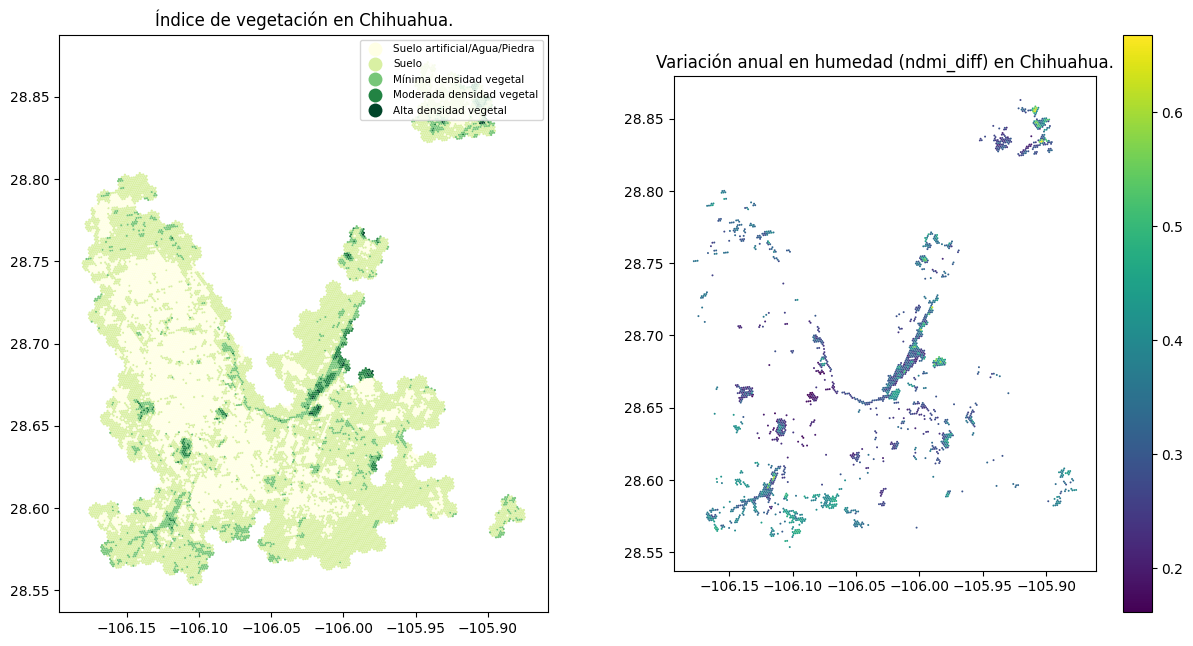

In [27]:
fig, ax = plt.subplots(1,2,figsize=(15,7.5))

#---------- Ax 0 ----------
ax[0].set_title('Índice de vegetación en {}.'.format(city))
ndvi_ndmi_marg.plot('ndvi_median_rango', 'YlGn', ax=ax[0],legend=True,
                    legend_kwds={'fontsize':7.5,'loc':'best'})

#---------- Ax 1 ----------
ax[1].set_title('Variación anual en humedad (ndmi_diff) en {}.'.format(city))
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[1], legend=True)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmidiff_{}.svg".format(city.lower(),city.lower()))

### Data analysis - Boxplot

In [28]:
boxplot_gdf = ndvi_ndmi_marg.copy()
boxplot_gdf = boxplot_gdf.sort_values('Grado_Marg')
boxplot_gdf.loc[boxplot_gdf.Grado_Marg.isna()]

,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg


      index  Grado_Marg
4  Muy Alto         882
3      Alto        1127
2     Medio        1911
1      Bajo        7203
0  Muy bajo       10584


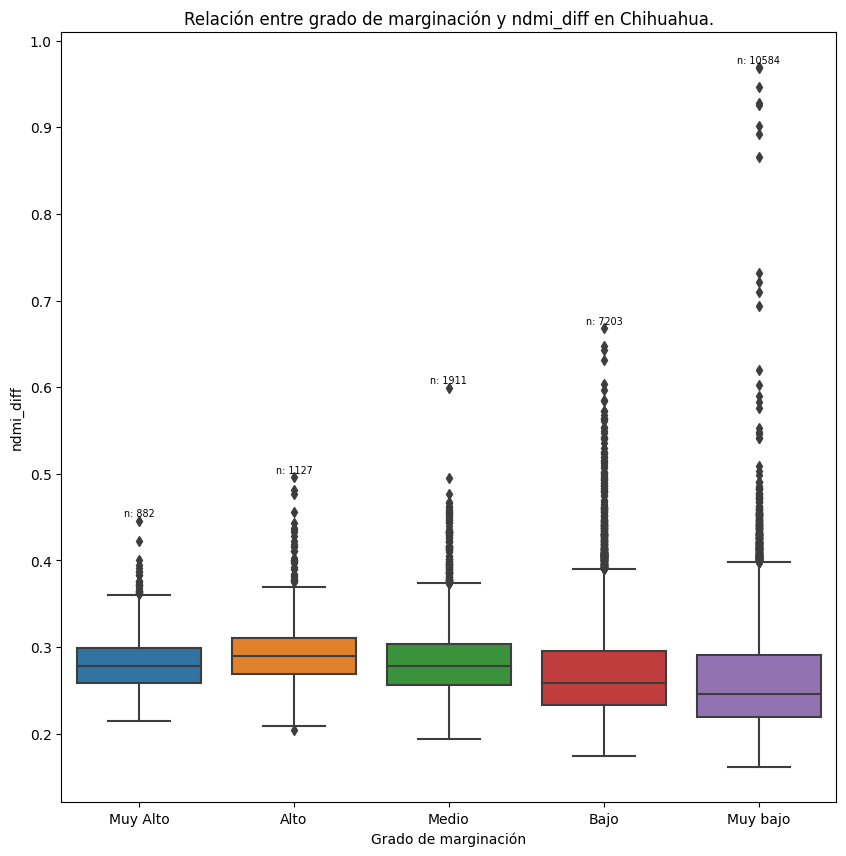

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

#---------Plot
sns.boxplot(x=np.array(boxplot_gdf.Grado_Marg) , 
            y=np.array(boxplot_gdf.ndmi_diff), 
            ax=ax)

#---------Format
plt.title('Relación entre grado de marginación y ndmi_diff en {}.'.format(city))
plt.xlabel('Grado de marginación')
plt.ylabel('ndmi_diff')

# ------------------------------------------- Add number of hex per marginalization group -------------------------------------------

#---------Position
#Calculate max of each Marginalization group to position number of observations above each boxplot
maxs = boxplot_gdf.groupby(['Grado_Marg'])['ndmi_diff'].max()
num_maxs = maxs.values
#Drop NaNs
num_maxs = num_maxs[~np.isnan(num_maxs)]

#---------Count
#Calculate number of observations per group
obs = boxplot_gdf['Grado_Marg'].value_counts()
obs = obs.reset_index()
obs = obs.sort_values('index')
print(obs)
#Drop Ceros by turning them to nans
obs = obs['Grado_Marg'].apply(lambda x: np.nan if x==0 else x)
obs = obs[~np.isnan(obs)]

num_obs = obs.values
num_obs = [str(x) for x in num_obs.tolist()]
num_obs = ["n: " + i for i in num_obs]

#---------Add it to the plot
pos = range(len(num_obs))
for tick,label in zip(pos,ax.get_xticklabels()):
    #ax.text(x,y,text)
    ax.text(pos[tick],
            num_maxs[tick] + 0.005,
            num_obs[tick],
            horizontalalignment='center',
            size='x-small',
            color='black')
# ------------------------------------------- ------------------------------------------- -------------------------------------------

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmidiff_marg_boxplot_{}.svg".format(city.lower(),city.lower()))

### Data treatment - Find mins and maxs ndmi_diff

Find 10% mins and 10% maxs

In [30]:
# Finding len of 10% of data
tenpercent = int(len(data_withveg)/10)

#Finding smallest and largest ndmi_diff
ndmi_diff_mins = data_withveg.nsmallest(tenpercent,'ndmi_diff')
ndmi_diff_maxs = data_withveg.nlargest(tenpercent,'ndmi_diff')

Create maxs and mins category

In [31]:
ndmi_diff_mins['ndmi_diff_cat'] = '10%_mins'
ndmi_diff_maxs['ndmi_diff_cat'] = '10%_maxs'

ndmi_diff_extremes = pd.concat([ndmi_diff_mins, ndmi_diff_maxs])

print(ndmi_diff_extremes.shape)
ndmi_diff_extremes.head(2)

(380, 24)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg,ndmi_diff_cat
14248,8a481b4864cffff,"POLYGON ((-106.08511 28.65844, -106.08443 28.6...",10,0.426603,0.097726,0.465097,0.497388,0.265563,0.231825,-0.001271,...,0.113980,0.083363,0.097112,0.230102,0.068658,0.161444,-0.000491,Moderada densidad vegetal,Muy bajo,10%_mins
21695,8a481b4867a7fff,"POLYGON ((-106.08805 28.65814, -106.08736 28.6...",10,0.223320,0.049005,0.238619,0.261468,0.143015,0.118453,-0.000834,...,0.066536,0.087333,0.054608,0.186231,0.023933,0.162298,-0.000773,Mínima densidad vegetal,Muy bajo,10%_mins


Plot data to get a visual

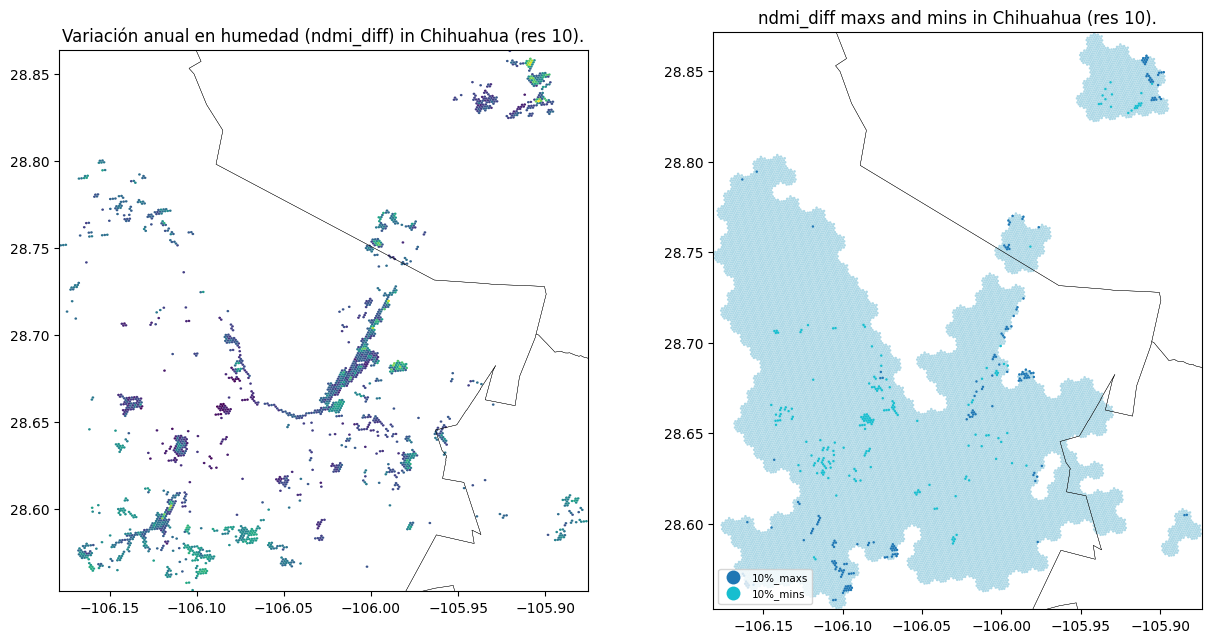

In [32]:
#Create figure
fig,ax = plt.subplots(1,2,figsize=(15,7.5))

#--------- First ax ---------
#Plotting ndmi_diff
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[0], zorder = 0)
#Plot municipalities
mun_gdf.plot(facecolor="none", edgecolor='black', lw=0.25, ax=ax[0], zorder = 1)

##---------Format
ax[0].set_title('Variación anual en humedad (ndmi_diff) in {} (res 10).'.format(city))

# Set the extents of the plot to match the base hexes data
ax[0].set_xlim(data_withveg.total_bounds[0], data_withveg.total_bounds[2])
ax[0].set_ylim(data_withveg.total_bounds[1], data_withveg.total_bounds[3])


#--------- Second ax ---------
#Plot base hexes
ndvi_ndmi_marg.plot(color = 'lightblue',ax=ax[1], zorder = 0)
#Plot municipalities
mun_gdf.plot(facecolor="none", edgecolor='black', lw=0.25, ax=ax[1], zorder = 1)
#Plot extremes data
ndmi_diff_extremes.plot('ndmi_diff_cat',ax=ax[1],zorder = 2, 
                        legend=True, legend_kwds={'fontsize':7.5,'loc':'lower left'})

##---------Format
ax[1].set_title('ndmi_diff maxs and mins in {} (res 10).'.format(city))

# Set the extents of the plot to match the base hexes data
ax[1].set_xlim(ndvi_ndmi_marg.total_bounds[0], ndvi_ndmi_marg.total_bounds[2])
ax[1].set_ylim(ndvi_ndmi_marg.total_bounds[1], ndvi_ndmi_marg.total_bounds[3])
#agregar pad

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmidiff_minsandmaxs_{}.svg".format(city.lower(),city.lower()))

### Data analysis - San Pedro edition

In [33]:
#San Pedro
#sanpedro = mun_gdf.loc[(mun_gdf.NOMGEO == 'San Pedro Garza García')]
#sanpedro = sanpedro.set_crs("EPSG:4326")

# % de hexs de ndmi_diff que se encuentran en San Pedro
#sanpedro_ndmidiff_hexs = gpd.overlay(data_withveg,sanpedro,keep_geom_type=True)
#print(sanpedro_ndmidiff_hexs.shape)
 
# % de hexs dentro del 10% que conserva más humedad que se encuentran en San Pedro
#sanpedro_ndmidiff_mins = gpd.overlay(ndmi_diff_extremes,sanpedro,keep_geom_type=True)
#sanpedro_proportions = sanpedro_ndmidiff_mins.groupby('ndmi_diff_cat').count()
#sanpedro_proportions

### Data analysis - Clean data and export to csv

Clean gdf

In [34]:
columns_tokeep = ['hex_id','res','ndmi_diff','ndmi_diff_cat','im_2020','imn_2020','Grado_Marg','city','geometry']
ndmi_diff_extremes_c = ndmi_diff_extremes[columns_tokeep]
                  
#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(380, 9)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry
14248,8a481b4864cffff,10,0.161444,10%_mins,125.655599,0.981574,Muy bajo,Chihuahua,"POLYGON ((-106.08511 28.65844, -106.08443 28.6..."
21695,8a481b4867a7fff,10,0.162298,10%_mins,125.862880,0.983194,Muy bajo,Chihuahua,"POLYGON ((-106.08805 28.65814, -106.08736 28.6..."


Data linear transformation in order to produce desired 3D map

In [35]:
#Linear intepolation data
x1 = ndmi_diff_extremes_c['ndmi_diff'].max()
y1 = ndmi_diff_extremes_c['ndmi_diff'].min()

x2 = ndmi_diff_extremes_c['ndmi_diff'].min()
y2 = ndmi_diff_extremes_c['ndmi_diff'].max()

m = (y2-y1)/(x2-x1)
b = y1-m*x1

# Convert all ndmi_diff to its opossite value in that linear interpolation (y=mx+b)
ndmi_diff_extremes_c['ndmi_diff_opossite'] = ndmi_diff_extremes_c['ndmi_diff'].apply(lambda x: m*x+b)

#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(380, 10)


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry,ndmi_diff_opossite
14248,8a481b4864cffff,10,0.161444,10%_mins,125.655599,0.981574,Muy bajo,Chihuahua,"POLYGON ((-106.08511 28.65844, -106.08443 28.6...",0.667931
21695,8a481b4867a7fff,10,0.162298,10%_mins,125.862880,0.983194,Muy bajo,Chihuahua,"POLYGON ((-106.08805 28.65814, -106.08736 28.6...",0.667078


Export to csv

In [38]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = ndmi_diff_extremes_c.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../output//figures/ndvi_ndmi_marg_bycity/{}/ndmi_diffextremes_marg_{}.csv".format(city.lower(),city.lower()))

(380, 10)
